<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/12_skimlit_nlp_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get the Data

In [163]:
!nvidia-smi

Sun Nov  7 12:59:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |  16023MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [164]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [165]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [166]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [167]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### preprocess Data

In [168]:
# Function to preprocess data

def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [169]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [170]:
len(train_lines)

210040

In [171]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] =  len(abstract_line_split) -1 
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [172]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [173]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [174]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [175]:
import pandas as pd

In [176]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [177]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [178]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

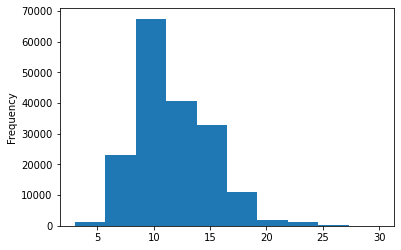

In [179]:
train_df.total_lines.plot.hist()

### get lists of sentences

In [180]:
train_sentences= train_df["text"].tolist()
val_sentences= val_df["text"].tolist()
test_sentences= test_df["text"].tolist()

In [181]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [182]:
train_sentences[1]

'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

### Make numeric Labels

In [183]:
# one hot Encoding of labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [184]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [185]:
import tensorflow as tf 
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [186]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [187]:
train_labels_encoded[:50]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4, 4, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 0, 3, 2, 2, 2, 2, 4,
       4, 4, 4, 4, 1, 1])

In [188]:
num_classes  = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0 : Baseline model

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [190]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

In [191]:
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [192]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score*100

72.1832384482987

In [193]:
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

### Getting Helper Function

In [194]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-07 12:59:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-07 12:59:38 (50.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [195]:
from helper_functions import calculate_results

In [196]:
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_pred)

In [197]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing the data for Deep Sequencing models

In [198]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [199]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [200]:
sent_lens[:5]

[49, 27, 15, 14, 35]

In [201]:
avg_sent_len = np.mean(sent_lens)
round(avg_sent_len)

26

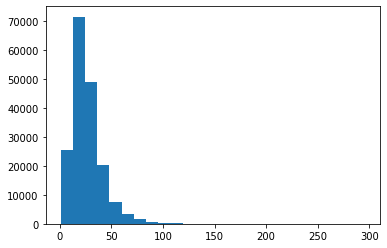

In [202]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [203]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

### Text Vectorizer Layer

In [204]:
max_tokens = 68000

In [205]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [206]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [207]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [208]:
!nvidia-smi

Sun Nov  7 12:59:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |  16023MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [209]:
import random
target_sentence = random.choice(train_sentences)
target_sentence, len(target_sentence), text_vectorizer([target_sentence])

('lornoxicam added to lidocaine ivra increased the sensory block recovery time without increasing side effects and increased first analgesic requirement time at the postoperative period when compared to lidocaine ivra ( p < @ , p < @ respectively ) and fentanyl added to lidocaine ivra ( p < @ , p < @ respectively ) .',
 316,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[ 7498,  1192,     6,  1253, 10707,    96,     2,  1616,   558,
           393,    63,   159,   575,   493,    71,     3,    96,   152,
           950,  2240,    63,    15,     2,   163,   173,   183,    34,
             6,  1253, 10707,    14,    14,    83,     3,  1495,  1192,
             6,  1253, 10707,    14,    14,    83,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>)

In [210]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab), rct_20k_text_vocab[:5], rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [211]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Creating a Embedding Layer

In [212]:
# token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=False,
                               name="Token_embedding")

In [213]:
target_sentence, text_vectorizer([target_sentence]), token_embed(text_vectorizer([target_sentence]))

('lornoxicam added to lidocaine ivra increased the sensory block recovery time without increasing side effects and increased first analgesic requirement time at the postoperative period when compared to lidocaine ivra ( p < @ , p < @ respectively ) and fentanyl added to lidocaine ivra ( p < @ , p < @ respectively ) .',
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[ 7498,  1192,     6,  1253, 10707,    96,     2,  1616,   558,
           393,    63,   159,   575,   493,    71,     3,    96,   152,
           950,  2240,    63,    15,     2,   163,   173,   183,    34,
             6,  1253, 10707,    14,    14,    83,     3,  1495,  1192,
             6,  1253, 10707,    14,    14,    83,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>,
 <tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[-0.03848529, -0.00724738, -0.00393902, ...,  0.00273539,
          -0.02169768, -0.03267746],
         [ 0.0171576

In [214]:
token_embed(text_vectorizer([target_sentence])).shape

TensorShape([1, 55, 128])

### Better performances with tf datasets

In [215]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [216]:
train_datasets

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [217]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
valid_datasets = valid_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [218]:
train_datasets

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D

In [219]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [220]:
model_1.summary()

Model: "model_1_Conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 55)                0         
_________________________________________________________________
Token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 51, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
__________________________________________

In [221]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(train_datasets,
            epochs=5,
            steps_per_epoch = int(0.1 * len(train_datasets)),
            validation_data=valid_datasets,
            validation_steps = int(0.1 * len(valid_datasets)))

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9304 - accuracy: 0.6316 - val_loss: 0.7209 - val_accuracy: 0.7247
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6892 - accuracy: 0.7416 - val_loss: 0.6679 - val_accuracy: 0.7586
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6453 - accuracy: 0.7633 - val_loss: 0.6222 - val_accuracy: 0.7756
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6119 - accuracy: 0.7784 - val_loss: 0.5978 - val_accuracy: 0.7839
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6044 - accuracy: 0.7886 - val_loss: 0.5743 - val_accuracy: 0.7965


In [222]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.5735 - accuracy: 0.7968


[0.5735355019569397, 0.7967694997787476]

In [223]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.67694955646762,
 'f1': 0.7938695392772984,
 'precision': 0.7960737153049166,
 'recall': 0.7967694955646762}

In [224]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [225]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [226]:
model_1_1_history = model_1.fit(train_datasets,
            epochs=5,
            validation_data=valid_datasets,
            )

Epoch 1/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.5054 - accuracy: 0.8158 - val_loss: 0.4933 - val_accuracy: 0.8168
Epoch 2/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.3702 - accuracy: 0.8705 - val_loss: 0.5185 - val_accuracy: 0.8160
Epoch 3/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.2368 - accuracy: 0.9235 - val_loss: 0.6153 - val_accuracy: 0.7992
Epoch 4/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.1317 - accuracy: 0.9607 - val_loss: 0.7499 - val_accuracy: 0.7901
Epoch 5/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.0703 - accuracy: 0.9808 - val_loss: 0.9350 - val_accuracy: 0.7779


In [227]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.9350 - accuracy: 0.7779


[0.9349671602249146, 0.7779359221458435]

In [228]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.79359195021846,
 'f1': 0.7766180981407058,
 'precision': 0.7801395516956234,
 'recall': 0.7779359195021845}

### Model 2: Feature Extraction with pretrained token embeddings

In [229]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [230]:
# Model 2
model_2 = tf.keras.Sequential([
                               tf_hub_embedding_layer,
                               layers.Dense(128, activation="relu"),
                               layers.Dense(5, activation="softmax")
])

model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [231]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_24 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [232]:
model_2.fit(train_datasets,
            steps_per_epoch=int(0.1 * len(train_datasets)),
            epochs=3,
            validation_data=valid_datasets,
            validation_steps=int(0.1 * len(valid_datasets)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9208 - accuracy: 0.6479 - val_loss: 0.7977 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7683 - accuracy: 0.7026 - val_loss: 0.7542 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7505 - accuracy: 0.7135 - val_loss: 0.7358 - val_accuracy: 0.7141


In [233]:
model_2.evaluate(valid_datasets)

945/945 [==============================] - 9s 10ms/step - loss: 0.7386 - accuracy: 0.7146


[0.7386229634284973, 0.7145836353302002]

In [234]:
model_2_pred_probs = model_2.predict(valid_datasets)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.45836091619225,
 'f1': 0.711546051913884,
 'precision': 0.714952401687502,
 'recall': 0.7145836091619224}

In [236]:
# Making trainable=True
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="universal_sentence_encoder")

InternalError: ignored

In [ ]:
# Model 2_1
model_2_1 = tf.keras.Sequential([
                               tf_hub_embedding_layer,
                               layers.Dense(128, activation="relu"),
                               layers.Dense(5, activation="softmax")
])

model_2_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_1.summary()

In [ ]:
model_2_1.fit(train_datasets,
            steps_per_epoch=int(0.1 * len(train_datasets)),
            epochs=5,
            validation_data=valid_datasets,
            validation_steps=int(0.1 * len(valid_datasets)))

In [ ]:
model_2_1.evaluate(valid_datasets)

In [ ]:
model_2_1_pred_probs = model_2_1.predict(valid_datasets)
model_2_1_preds = tf.argmax(model_2_1_pred_probs, axis=1)
model_2_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_1_preds)
model_2_1_results

### Model 3: Conv1D with character embeddings

In [ ]:
# Function to split sentences to characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(target_sentence)

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_chars[0]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

In [ ]:
plt.hist(char_lens, bins=7);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
len(alphabet), alphabet

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab, len(char_vocab)

In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

In [ ]:
# token embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=25,
                               mask_zero=False,
                               name="Char_embedding")

In [ ]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

In [ ]:
# Model 3
inputs = layers.Input(shape=(1,), dtype="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv_1d")

In [ ]:
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

In [ ]:
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
val_chars[0]

In [ ]:
model_3_history = model_3.fit(train_char_datasets,
                              steps_per_epoch=int(0.1*len(train_char_datasets)),
                              epochs=5,
                              validation_data=val_char_datasets,
                              validation_steps=int(0.1*len(val_char_datasets)))

In [ ]:
model_3.evaluate(val_char_datasets)

In [ ]:
model_3_pred_probs = model_3.predict(val_char_datasets)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

### Model 4: Combining pretrained token embeddings and characters embeddings

In [ ]:
# Model 4

#1. Setup token inputs/Model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

#2. Setup Char inputs/models
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3. concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_concate")([token_model.output,
                                                                   char_model.output])

#4. Create outputs layers- adding in droupouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

#5.model with token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")



In [ ]:
# compile the model
model_4.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Combine chars and tokens into single inputs
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

In [ ]:
!nvidia-smi

In [ ]:
model_4.evaluate(val_char_token_dataset)

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

In [ ]:
# Use one-hot-encoding for the "line-number" coloum
train_line_numbers_oht = tf.one_hot(train_df["line_number"].to_numpy(), depth=20)
val_line_numbers_oht = tf.one_hot(val_df["line_number"].to_numpy(), depth=20)
test_line_numbers_oht = tf.one_hot(test_df["line_number"].to_numpy(), depth=20)

train_line_numbers_oht[:10], train_line_numbers_oht.shape

In [ ]:
# Total lines
train_df["total_lines"].value_counts()

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

In [ ]:
# Use one-hot-encoding for the "total_lines" coloum
train_total_lines_oht = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_oht = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_oht = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_oht[:10], train_total_lines_oht.shape

## building a tribrid model

In [ ]:
#1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

#3. Line numbers
line_number_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

#4. total lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

#5. combine token and char embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

#Droupout layer
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

#7. output layer
output_layer = layers.Dense(5, activation="relu", name="output_layer")(tribrid_embeddings)

#8. put together all inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

In [ ]:
plot_model(model_5,show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training and validation datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_oht,
                                                                train_total_lines_oht,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_oht,
                                                                val_total_lines_oht,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

In [ ]:
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

### Comparing the results of various models

In [ ]:
all_models_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                   "model_1_custom_token_embedding": model_1_results,
                                   "model_2_pretrained_token_embedding": model_2_results,
                                   "model_3_custom_char_embedding":model_3_results,
                                   "model_4_hybrid_char_token_embedding": model_4_results,
                                   "model_5_pos_char_token_embedding": model_5_results})

In [ ]:
all_models_results = all_models_results.transpose()
all_models_results

In [ ]:
all_models_results["accuracy"] = all_models_results["accuracy"]/100

In [ ]:
#plot
all_models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
all_models_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

### Saving the model

In [ ]:
import tensorflow_hub as hub

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")